In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexByteplot"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.6min


[CV] .............. C=0.01, gamma=1e-08, score=0.138751, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138889, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139165, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total= 4.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138751, total= 4.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.136986, total= 4.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  6.9min


[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.136986, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138477, total= 4.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137255, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.2min


[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 3.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total= 3.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139165, total= 3.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total= 3.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138751, total= 3.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total= 3.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.227006, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.2min


[CV] ............. C=0.01, gamma=0.0001, score=0.414062, total= 3.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.424213, total= 3.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.425197, total= 3.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.430267, total= 3.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.424182, total= 3.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.425595, total= 3.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.242334, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

In [16]:
top_model.cv_results_

{'mean_fit_time': array([ 232.00357072,  232.34077504,  215.89366431,  222.67224021,
         200.53314552,  190.09309833,  288.65077267,  303.41019218,
         319.31773071,  315.53195789,  207.10083346,  232.70071492,
         214.23831129,  182.63580298,   89.37948649,  116.54295666,
         262.7054204 ,  291.83924787,  300.88767793,  296.53758454,
         212.63924651,  215.94994895,  167.92627749,   84.42016735,
          42.84822793,   93.96176949,  243.64112332,  291.19346125,
         300.78091638,  301.00885122,  222.59691913,  172.47863297,
          85.38562667,   44.06055655,   33.18018744,  100.21811149,
         248.22064714,  300.47249336,  301.68632596,  301.63155417,
         171.41503546,   86.0689625 ,   44.08969483,   31.03720129,
          31.72759871,  102.59953258,  245.34348798,  294.00330763,
         312.02867954,  311.47173338,   85.11215456,   42.44695916,
          33.10637717,   32.01647761,   31.53018293,  109.7318763 ,
         261.21635613,  292.524

In [17]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.23264, std: 0.00431, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.42502, std: 0.00411, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.44436, std: 0.00745, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.25898, std: 0.00742, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.20116, std: 0.00628, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.15371, std: 0.00236, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.15371, std: 0.00236, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.23264, std: 0.00431, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.0001} - score: 0.9080


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


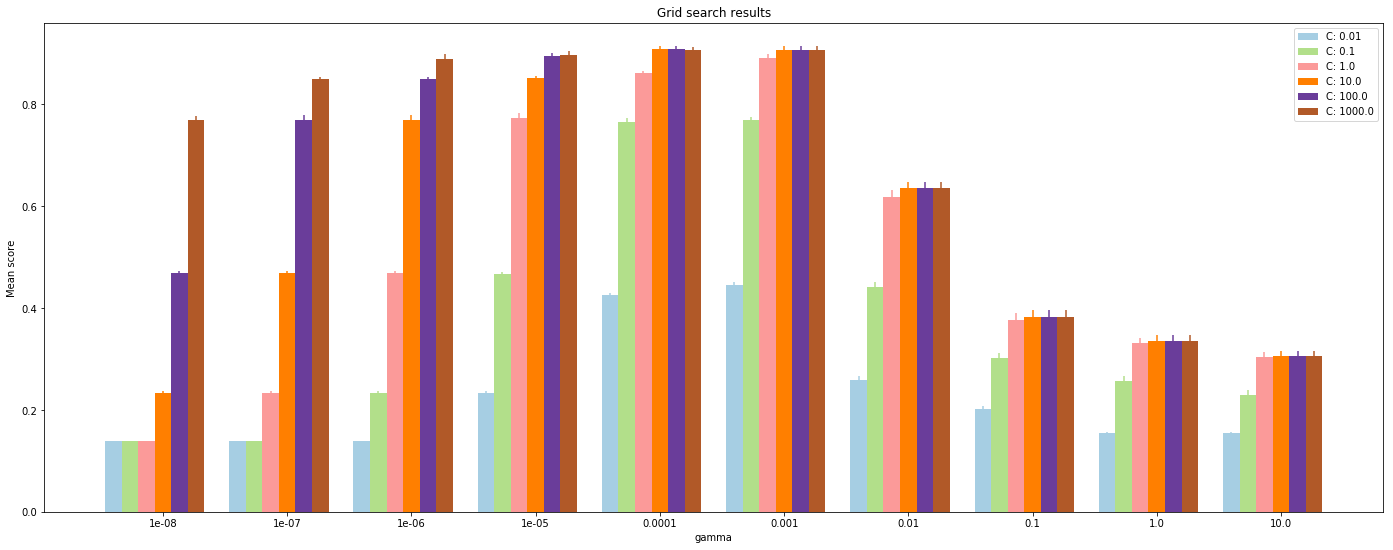

In [19]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()